In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import seaborn as sns
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import geopandas as gpd
import shapely.geometry

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain
from trajectory_post_funcs import calculate_heatmaps_from_trajectories

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')

HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

## a quick function that assigns each watershed a basin value 
## based on the first 2 numbers of the HUC8 identifier

basin_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    HUC2 = HUC8_ID[:2]
    if HUC2 == '14':
        basin = 'Colorado'
    elif HUC2 == '13':
        basin = 'Rio Grande'
    elif HUC2 == '11':
        basin = 'Arkansas'
    elif HUC2 == '10':
        basin = 'South Platte'
   
    basin_lst.append(basin)
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/latest/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
## add the basin name as a coord
ds = ds.assign_coords({'basin': ("HUC8", basin_lst)})
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 1388, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2019-12-28
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U12 'Colorado' 'Colorado' ... 'South Platte'
Data variables: (12/17)
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    uIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    vIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    IWV                 (HUC8, start_date, index) float64 nan nan ... nan nan
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_scale            (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar                  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT         (HUC8, start_date) float64 nan nan nan ... nan nan nan
Attributes:
    Conventions:                CF-1/0
    history:                    Fri Jul 17 11:51:01 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Fri Jul 17 11:51:01 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [4]:
ds_NDJFMA = select_months_ds(ds, 11, 4, 'start_date')
ds_MJJASO = select_months_ds(ds, 5, 10, 'start_date')

ds_lst = [ds_NDJFMA, ds_MJJASO]

ds_DJF = select_months_ds(ds, 12, 2, 'start_date')
ds_MAM = select_months_ds(ds, 3, 5, 'start_date')
ds_JJA = select_months_ds(ds, 6, 8, 'start_date')
ds_SON = select_months_ds(ds, 9, 11, 'start_date')

ds_lst2 = [ds_DJF, ds_MAM, ds_JJA, ds_SON]

NDJFMA Colorado
348.0
NDJFMA Rio Grande
90.0
NDJFMA South Platte
50.0
NDJFMA Arkansas
11.0
MJJASO Colorado
245.0
MJJASO Rio Grande
73.0
MJJASO South Platte
86.0
MJJASO Arkansas
94.0


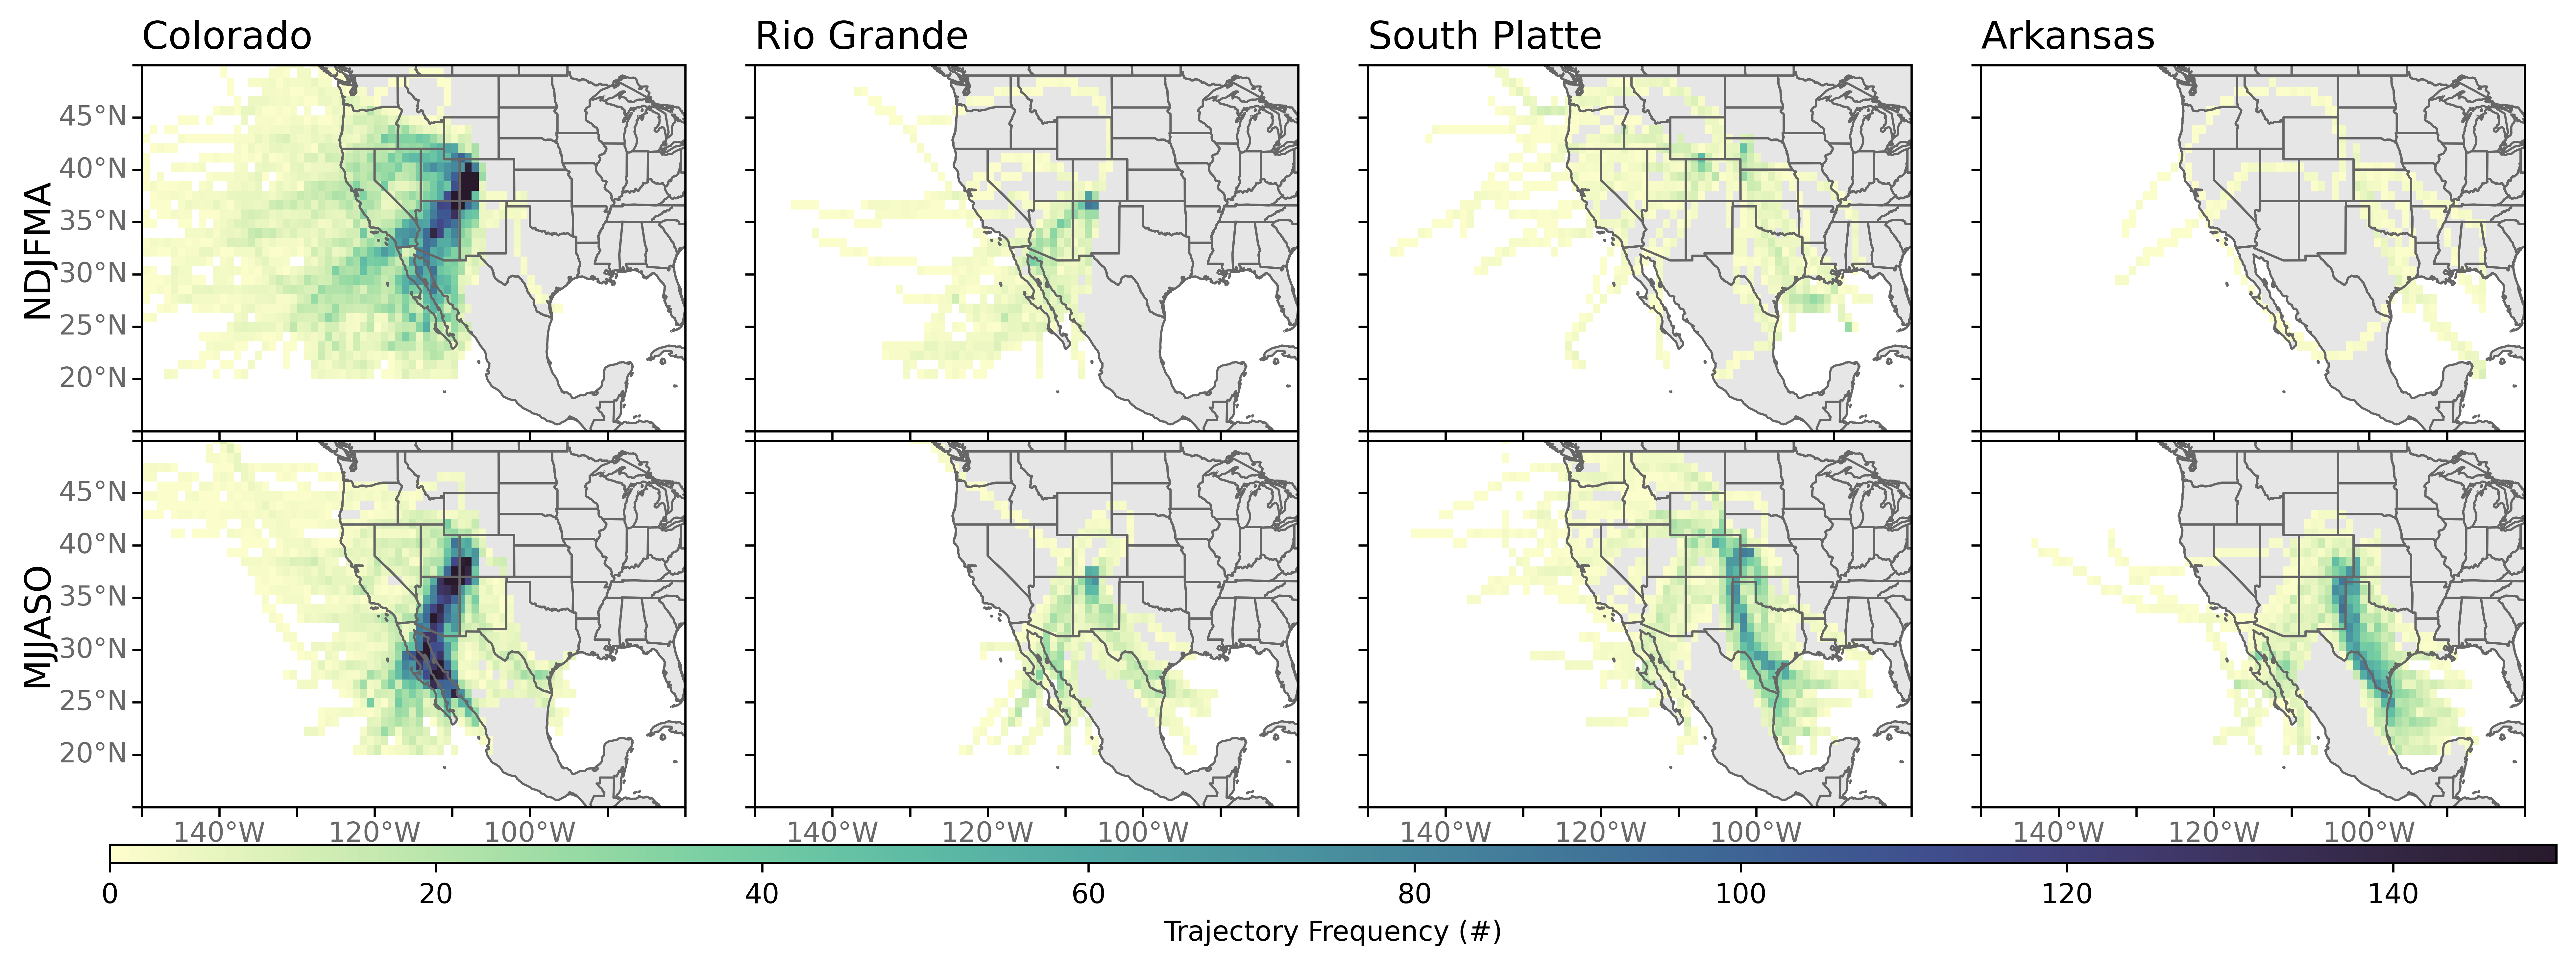

In [6]:
nrows = 4
ncols = 4

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext = [-150., -80., 15., 50.] 

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(16.0, 5.25))
fig.dpi = 600
fname = path_to_figs + 'heatmaps_basin_WY'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
left_lats = [True, False, False, False]
bottom_lons = [False, True]
ssn_lst = ['NDJFMA', 'MJJASO']
basin_lst = ['Colorado', 'Rio Grande', 'South Platte', 'Arkansas']

## Add color bar axis
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[i, j], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=left_lats[j], right_lats=False, bottom_lons=bottom_lons[i])
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if i == 0: # add column label to top row only
            ax.set_title(basin_name, loc='left', fontsize=14)
        
        if j == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, ssn_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst[i].where(ds_lst[i].basin==basin_name)
        AR = ds.where(ds.ar_scale > 0, drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR)
        
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmo.deep, vmin=0, vmax=150, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (#)", "orientation": "horizontal"})


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

DJF Colorado
272.0
DJF Rio Grande
57.0
DJF South Platte
36.0
DJF Arkansas
11.0
MAM Colorado
70.0
MAM Rio Grande
21.0
MAM South Platte
42.0
MAM Arkansas
23.0
JJA Colorado
36.0
JJA Rio Grande
19.0
JJA South Platte
39.0
JJA Arkansas
51.0
SON Colorado
232.0
SON Rio Grande
71.0
SON South Platte
54.0
SON Arkansas
40.0


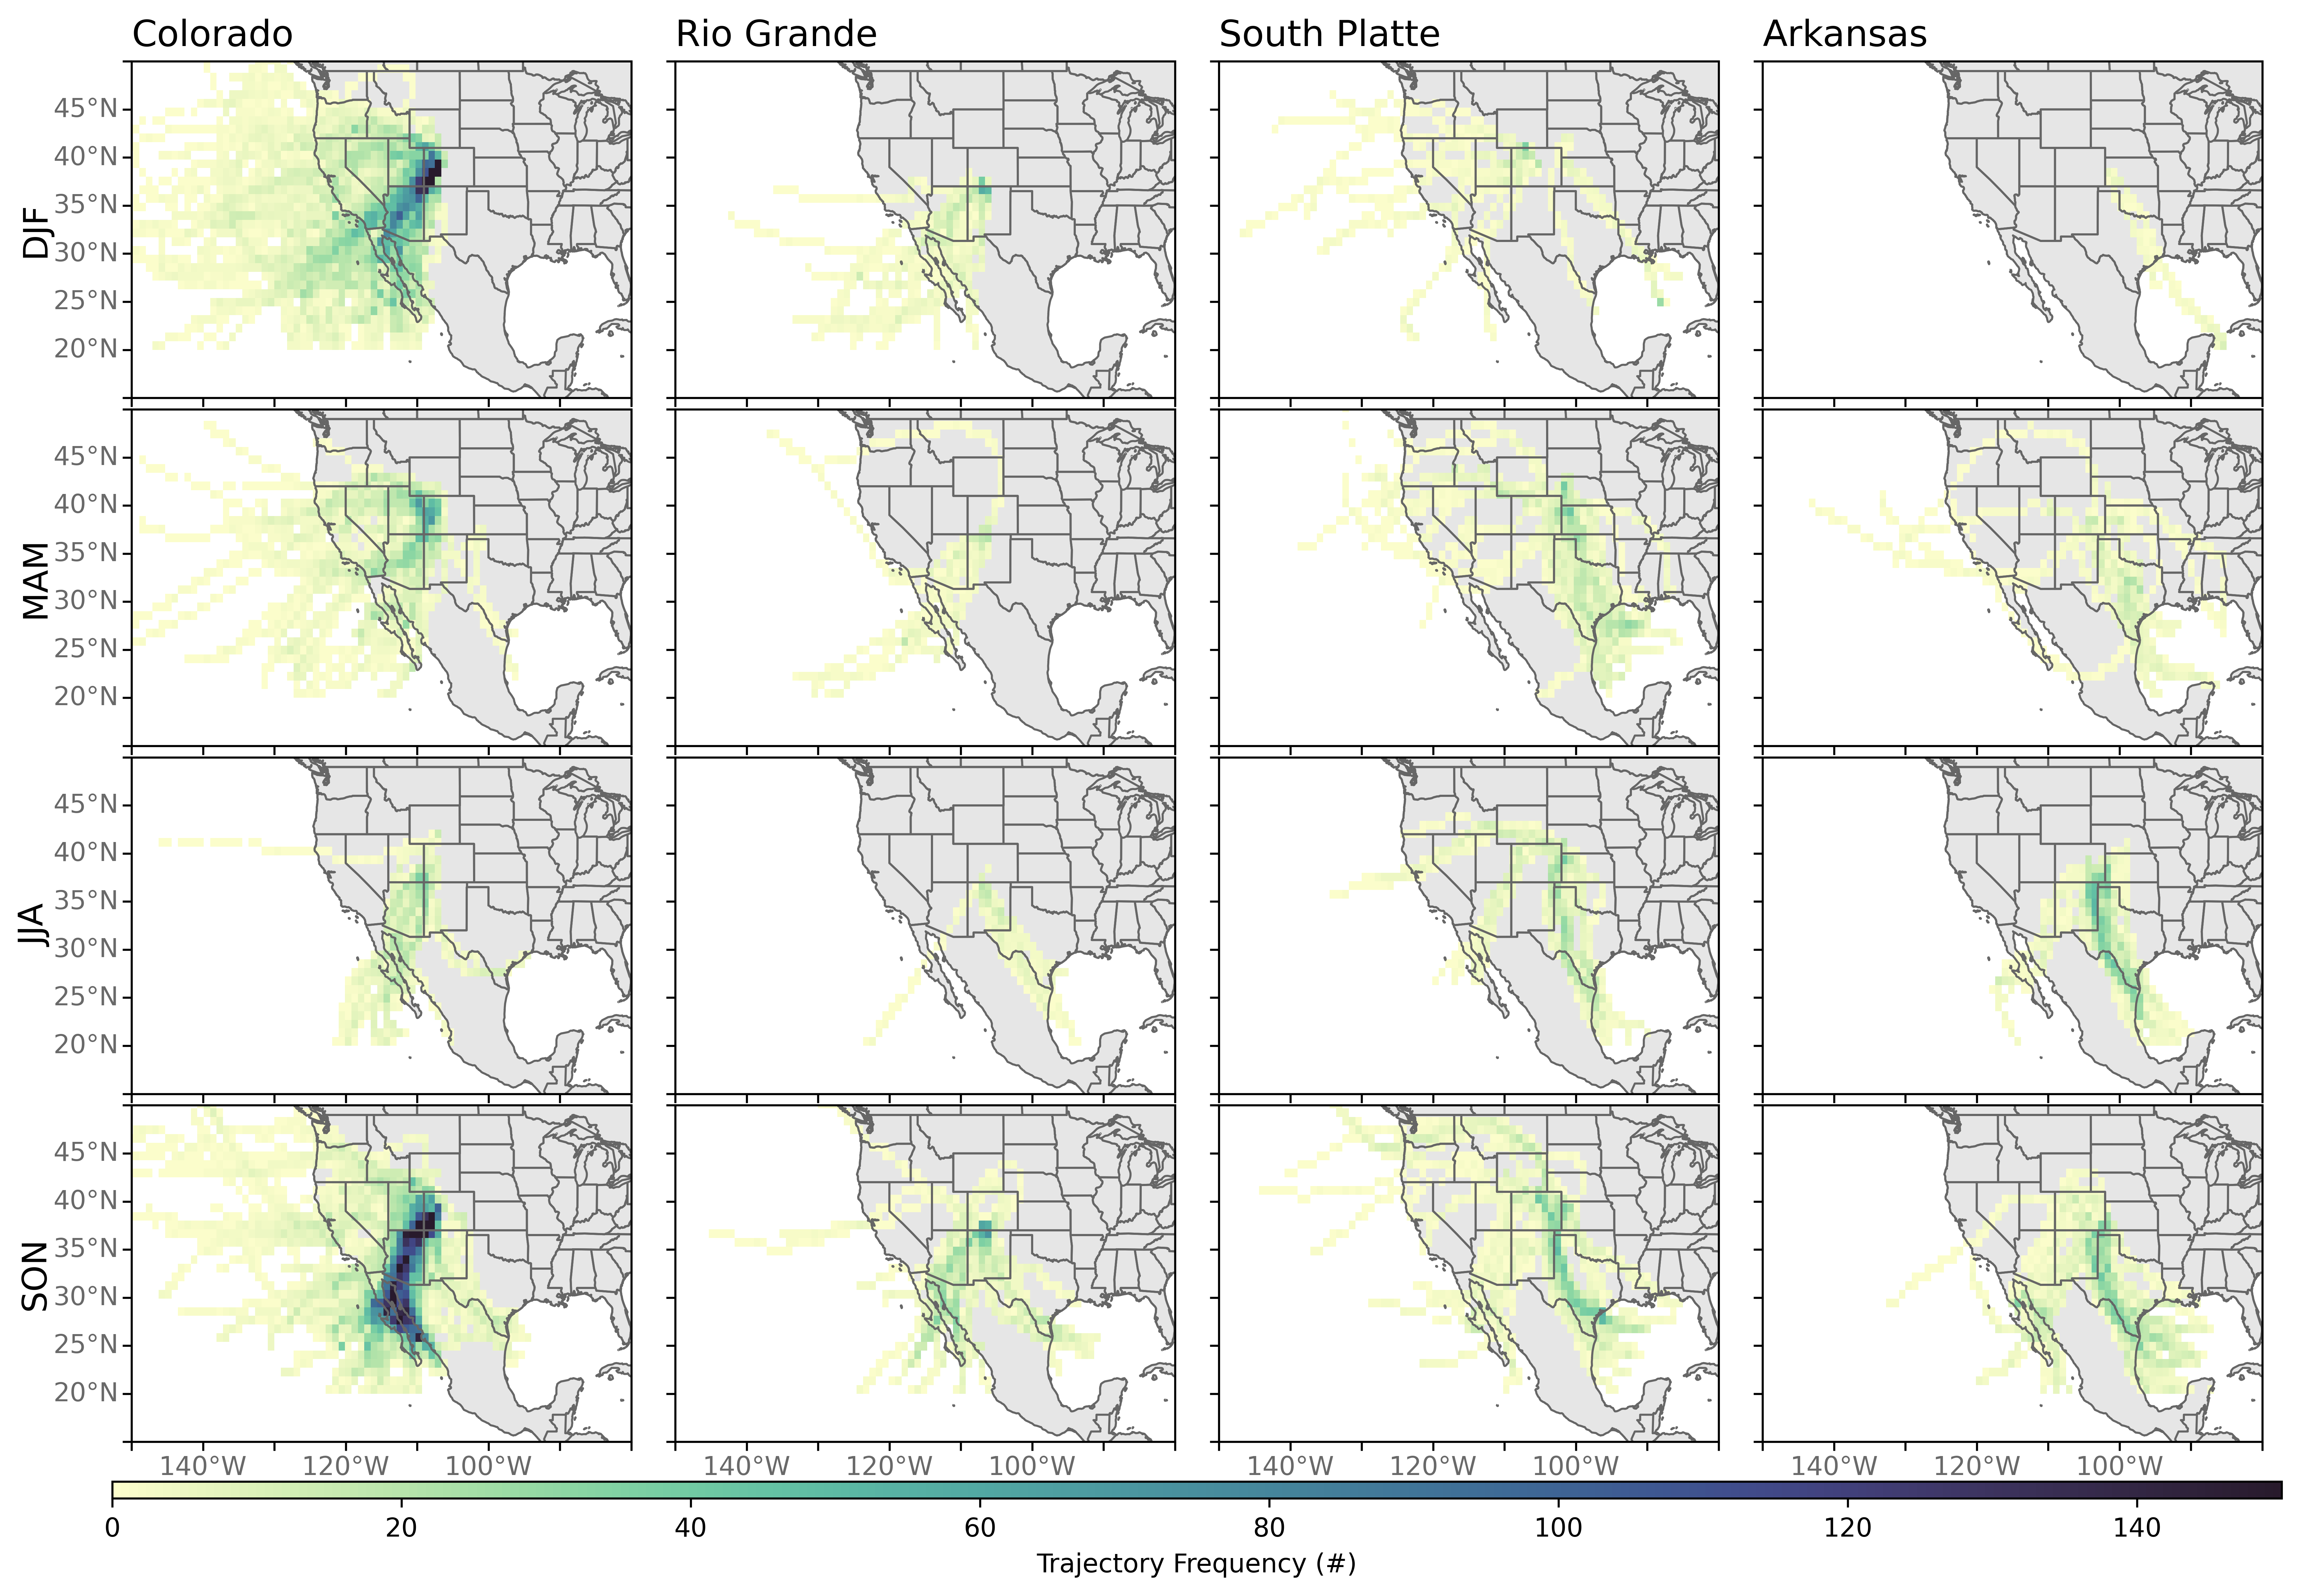

In [9]:
nrows = 6
ncols = 4

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext = [-150., -80., 15., 50.] 

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(15.0, 10.0))
fig.dpi = 600
fname = path_to_figs + 'heatmaps_basin_SSN'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['DJF', 'MAM', 'JJA', 'SON']
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
left_lats = [True, False, False, False]
bottom_lons = [False, False, False, True]
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
basin_lst = ['Colorado', 'Rio Grande', 'South Platte', 'Arkansas']

## Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[i, j], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=left_lats[j], right_lats=False, bottom_lons=bottom_lons[i])
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if i == 0: # add column label to top row only
            ax.set_title(basin_name, loc='left', fontsize=14)
        
        if j == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, ssn_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst2[i].where(ds_lst2[i].basin==basin_name)
        AR = ds.where(ds.ar_scale > 0, drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR)
        
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmo.deep, vmin=0, vmax=150, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (#)", "orientation": "horizontal"})


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()